# TA Review Session - 3
## Linear Algebra, Regression and Data Analysis in Python
### FINM September Launch

Maneet Singh - TA

maneetsingh@uchicago.edu

## Recap

- Linear models are an extremely important basic tool in mathematical finance, and in statistical machine learning.


- Most statistical machine learning methods (such as neural networks, regression trees, lasso and elastic-net, logistic classifiers, etc.) are direct generalizations of linear regression models (ie. they reduce to regression as a special case), or they use linear regression as an intermediate step.


- Time-series analysis often reduces to some sort of regression of values on lagged values from the same time series.


- It is impossible to overstate the importance of these techniques; every good quantitative researcher knows them.


**What have we discussed**

- In the last couple of sessions we discussed the OLS method for least squares, why it is the most useful method to estimate a linear model, and what are some of it's drawbacks.

$$
y = \hat{y} + \epsilon = x'\beta + \epsilon = x'\{ (x'x)^{-1}x'y \}+ \epsilon
$$

- While discussing the drawbacks, we also discussed the model assumptions, and how violating these assumptions can lead to problems with classical inference

- In particular we discussed how inverting the variance-covariance matrix $(x'x)^{-1}$ can lead to the following problems:

    - Invertibility in the rank deficient case
    - Instability in the high condition number case
    


###### Out-of-Sample Performance of OLS

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

retsx = pd.read_excel('sp500_returns.xlsx', sheet_name=2, index_col=0)
gld = pd.read_excel('sp500_returns.xlsx', sheet_name=3, index_col=0)[['GLD']]

In [2]:
retsx_train = retsx.loc[:'2020']
gld_train = gld.loc[:'2020']

retsx_test = retsx.loc['2021':]
gld_test = gld.loc['2021':]

model = LinearRegression().fit(X = retsx_train, y = gld_train)

print('In-Sample R-Squared: {:,.2%}'.format(model.score(X = retsx_train, y = gld_train)))
print('Out-of-Sample R-Squared: {:,.2%}'.format(model.score(X = retsx_test, y = gld_test)))
print('Number of features: {}'.format(model.n_features_in_))

In-Sample R-Squared: 100.00%
Out-of-Sample R-Squared: -53.71%
Number of features: 451


**In today's session we will focus on improving OLS through various techniques:**

1. Inverse in the case of a rank deficiency of $(x'x)$


2. Treating Linear Regression as an optimization problem


3. Adding constraints to the optimization problem: Penalized Regressions


4. Cross Validation and Generalization Error

## Moore-Penrose Pseudoinverse

In the case of a rank-deficient design matrix $x$, multiple projections of $y$ can exist on the vector-space spanned by $x$

- For any X , the objective function $||y - x'\beta||$ is bounded below (by zero), and one may show that minimizers always exist, but the minimizer need not be unique in the rank-deficient case.


- One way to render the problem well-defined in the rank-deficient case is to introduce an L2 penalty term:

$$
\hat{\beta}^{ridge}_\lambda = argmin \{||y − x'\beta||^2 + \lambda||\beta||^2\}
$$

if $\lambda > 0 $

$$
\hat{\beta}^{ridge}_\lambda = (x′x + \lambda I )^{−1}x′y
$$


This is called ridge regression.

It can be shown that $(x′x + \lambda I )^{−1}$, hence $\hat{\beta}^{ridge}_\lambda$ always exists independent on any conditions on $x$


- Interestingly, the limit as $\lambda \rightarrow 0$, from the right, of ridge regression also exists.


$$
X^+ = \lim_{\lambda \rightarrow 0^+}(x′x + \lambda I)^{−1}X′
$$

From which we can easily deduce

$$
\lim_{\lambda \rightarrow 0^+} \beta^{ridge}_\lambda = X^+y
$$

An ingenious idea due to Moore (1920) and Penrose (1955) is that whenever there exist multiple minimizers of $||y - x'\beta||$, we can pick one out as having the smallest norm.

The Moore-Penrose pseudoinverse $X^+$ is defined so that $X^+y$ is the minimum-norm vector among all minimizers of $||y − x \beta||^2.$

In [3]:
retsx_train_sample = retsx_train[['AAPL', 'MSFT']].copy()
retsx_train_sample['AAPL Copy'] = retsx_train_sample['AAPL']
print("Rank of X'X: {}".format(np.linalg.matrix_rank(retsx_train_sample.transpose() @ retsx_train_sample)))
print("Rank of X'X needed to be full rank: {}".format(min(retsx_train_sample.shape)))

Rank of X'X: 2
Rank of X'X needed to be full rank: 3


In [4]:
# This gives an error
np.linalg.inv(retsx_train_sample.transpose() @ retsx_train_sample) #Inverse method

LinAlgError: Singular matrix

In [5]:
np.linalg.pinv(retsx_train_sample.transpose() @ retsx_train_sample) #Pseudoinverse method

array([[ 0.99842951, -1.5940876 ,  0.99842951],
       [-1.5940876 ,  6.65929713, -1.5940876 ],
       [ 0.99842951, -1.5940876 ,  0.99842951]])

So we learn that Pseudoinverse helps solve the invertibility problem with OLS in the rank deficiency case. However, it still does not resolve the problem of instability caused by large condition numbers. Let's see how this can be resolved.

## Small Detour - Optimization approach to OLS with Gradient Descent

- Throughout this section we assume there is a function $f(θ)$ to be minimized without any constraints on $θ ∈ R^d$


- So, for OLS $f(\beta) = |y - x'\beta|^2$


- More generally, most machine learning methods are some form of descent algorithm applied to a loss function.

<div>
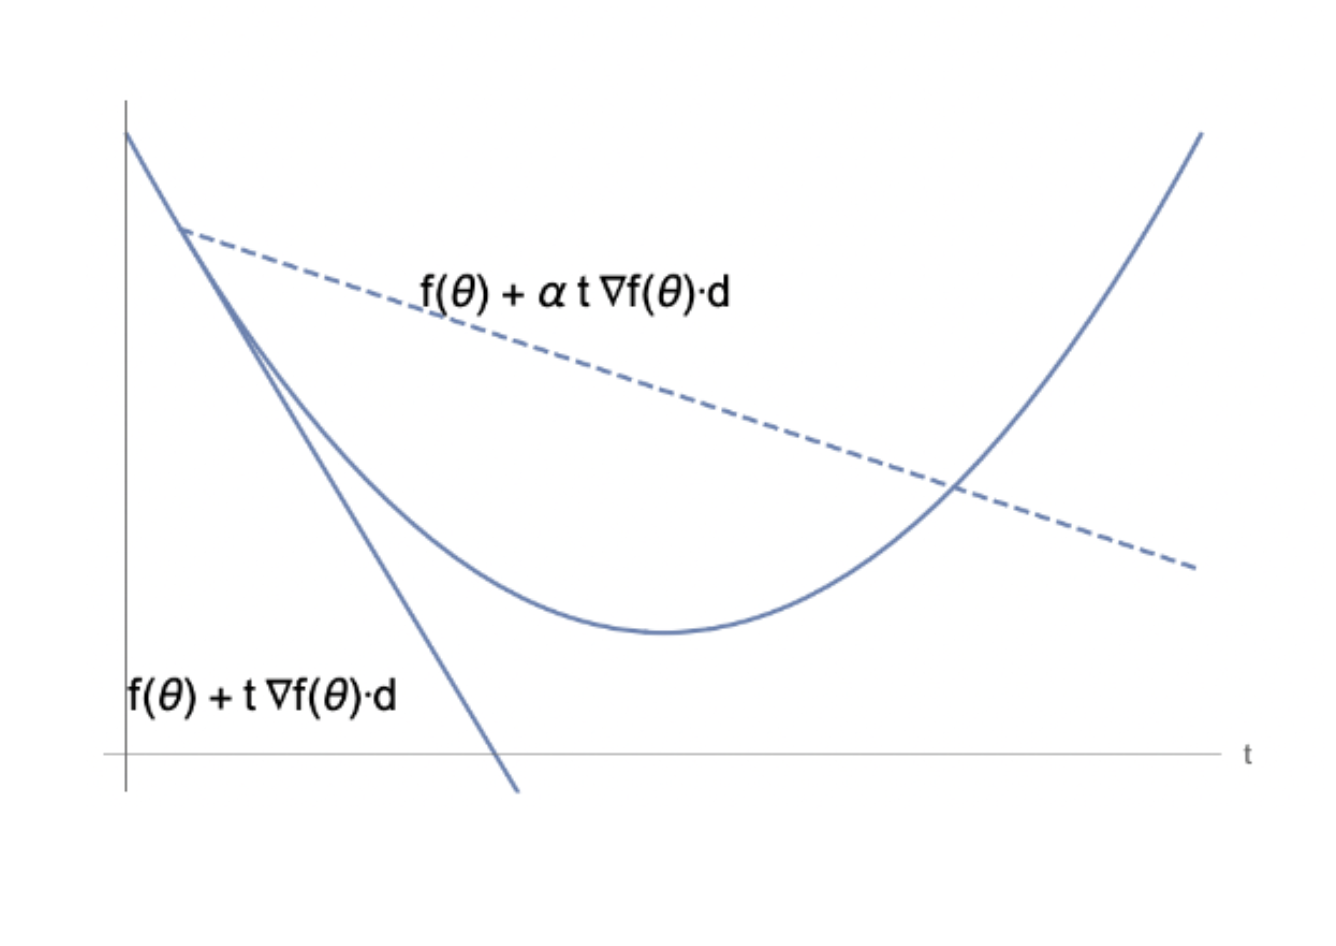
</div>

**Descent Directions**


A descent direction at θ is a vector d such that

$$
f (θ + ηd ) < f (θ)
$$

for all sufficiently small $η > 0$


Generally if d is some vector such that $$g.d < 0$$

where $g = ∇f(θ)$, then for sufficiently small η, by Taylor’s theorem we have

$$
f(θ+ηd ) = f (θ) + η g ·d + O(η_2)
$$


In other words, the negative gradient is always a descent direction unless the gradient is zero.


**Descent Algorithm**

A descent algorithm is an iterative procedure of the form
$$
θ_{k +1} = θ_k + η_k d_k
$$

together with some prescription for choosing $η_k$ and $d_k$. The algorithm is called gradient descent if the prescription for choosing $d_k$ is to take the negative gradient:

$$
d_k = −g_k = −∇f(θ_k)
$$

<div>
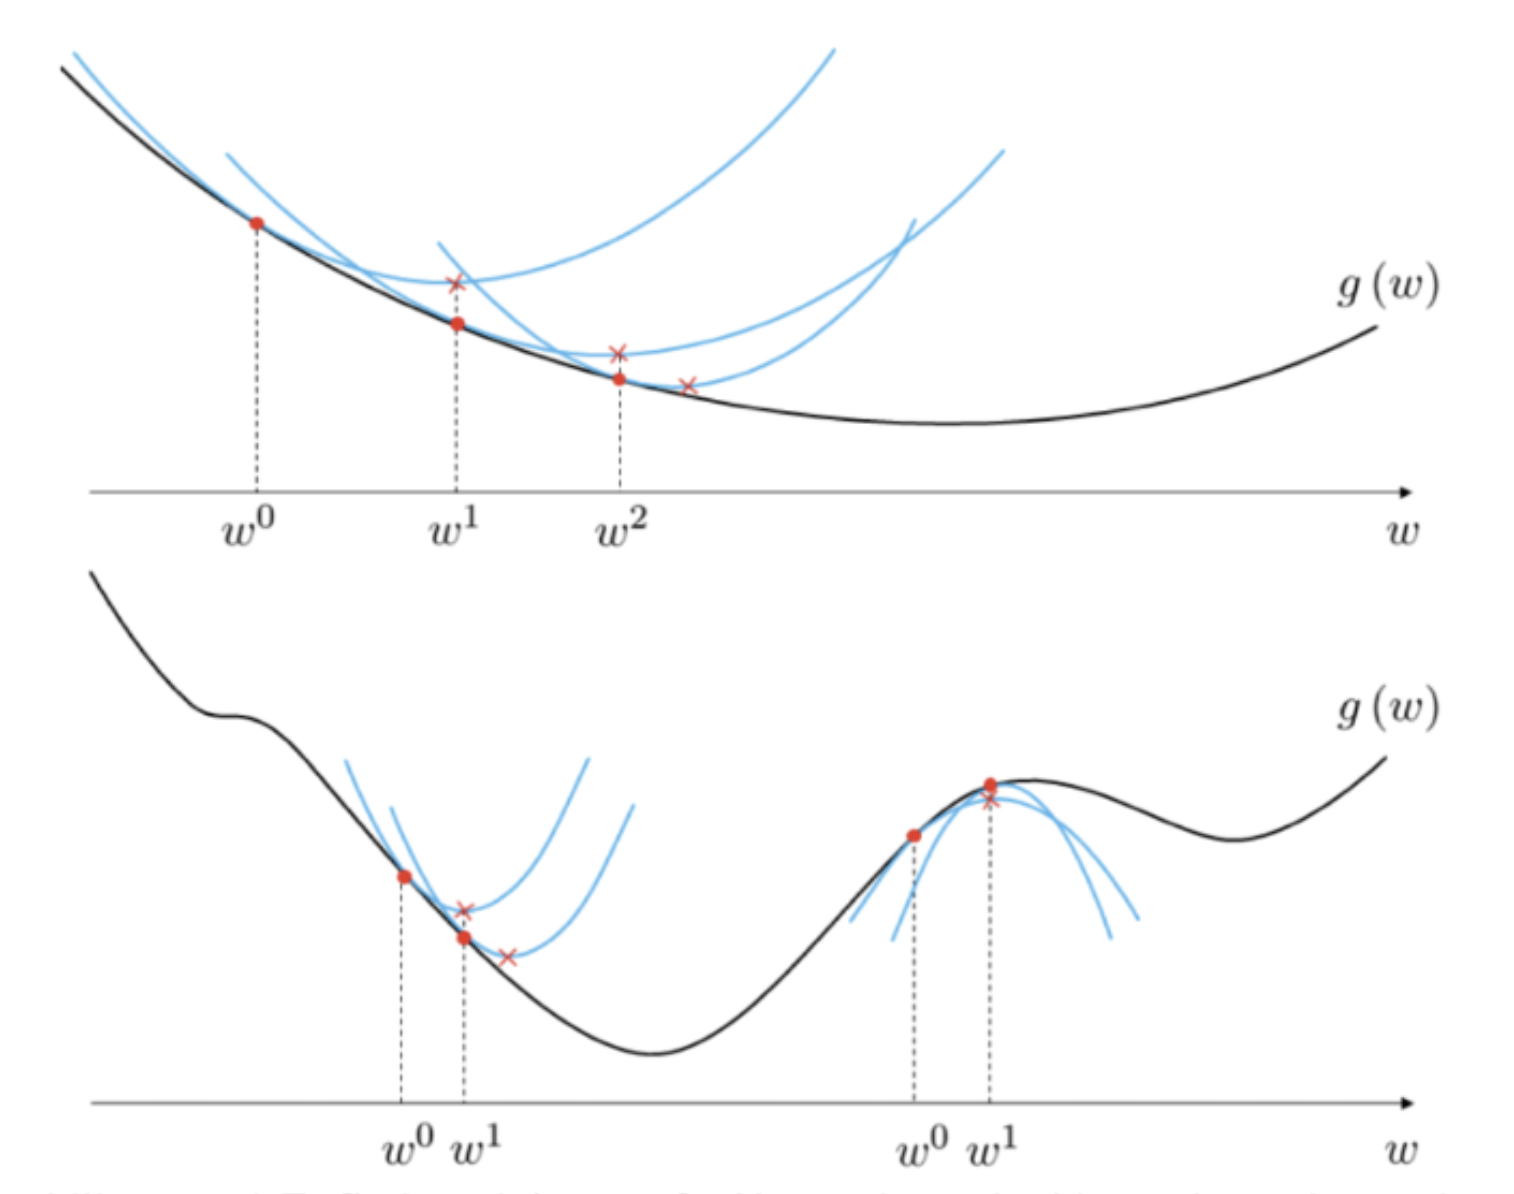
</div>

The cost function of regression $f(\beta) = y - x'\beta$, results in a smooth surface, hence the solution of gradient descent always converges to the normal equation. Read more about Gradient Descent here: https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931

Looking at OLS as an optimization problem allows us to constraint the value of $\beta$ resulting in an estimiate which is significantly more stable.

## Penalized Regressions - Lasso, Ridge and Elastic Net 

Consider the following constrained optimization problem:

$$
β = \min_β \{\sum_{i=1}^n (y_i − \sum^p_{j=1} x_{ij} β_j)^2\}
$$


subject to:

$$
\sum^p_{j=1}|β_j| <= t 
$$

If $t$ is chosen larger than $t_0 := \sum^p_{j=1}|\hat{β_j}|$, where $\hat{β_j}$ denote the least squares estimates, then the estimates are simply the least-squares $\hat{β_j}$

**But how do we find $t$? Solution: Minimize $\sum^p_{j=1}|β_j|$**

In other words:


$$
\min_{β_0 ∈ R, β ∈ R^p} f(β_0,β)
$$


where:
$$
f(β_0,β) := \frac{1}{2n}\sum_{i=1}^n (y_i − β_0 − g(x_i;β))^2 + λ \sum_j|β_j|
$$



Or more generally,

$$
\min_{β_0 ∈ R, β ∈ R^p} f(β_0,β)
$$


where:
$$
f(β_0,β) := \frac{1}{2n}\sum_{i=1}^n (y_i − β_0 − g(x_i;β))^2 + λ P_α(β)
$$

- The term proportional to $P_α(β)$ is called a penalty term; it penalizes vectors $β ∈ R^p$ with large values of the penalty function $P_α(β)$



- The penalty function is allowed to have its own internal parameters which we denote by α.



- The parameter(s) α are hyper-parameters which are usually viewed as exogenous, while the “complexity parameter” λ is usually chosen via cross-validation. The parameters α need not be present at all; for example, in LASSO one has a penalty term which does not depend on any hyperparameters.

$$
P_α(β) = \sum_j|β_j|
$$

### Lasso:

$$
\min_{β_0 ∈ R, β ∈ R^p} f(β_0,β)
$$


where:
$$
f(β_0,β) := \frac{1}{2n}\sum_{i=1}^n (y_i − β_0 − g(x_i;β))^2 + λ \sum_j|β_j|
$$



### Ridge:

$$
\min_{β_0 ∈ R, β ∈ R^p} f(β_0,β)
$$


where:
$$
f(β_0,β) := \frac{1}{2n}\sum_{i=1}^n (y_i − β_0 − g(x_i;β))^2 + λ \sum_j|β_j|^2
$$

### Elastic Net: 

$$
\min_{β_0 ∈ R, β ∈ R^p} f(β_0,β)
$$


where:
$$
f(β_0,β) := \frac{1}{2n}\sum_{i=1}^n (y_i − β_0 − g(x_i;β))^2 + λ \alpha \sum_j|β_j| + \frac{1}{2} λ (1-\alpha) \sum_j|β_j|^2
$$



While it's important to remember the terms in different penalized regressions, it is more important to note the effect of these regressions on $\beta$ estimates. Note that $\lambda$ controls how much effect the penalty term will have on the estimates. Higher $\lambda$ would result in a high penalty term, thereby resulting in a lower model complexity


#### Effect of $\beta$ for different penalty terms:

<div>
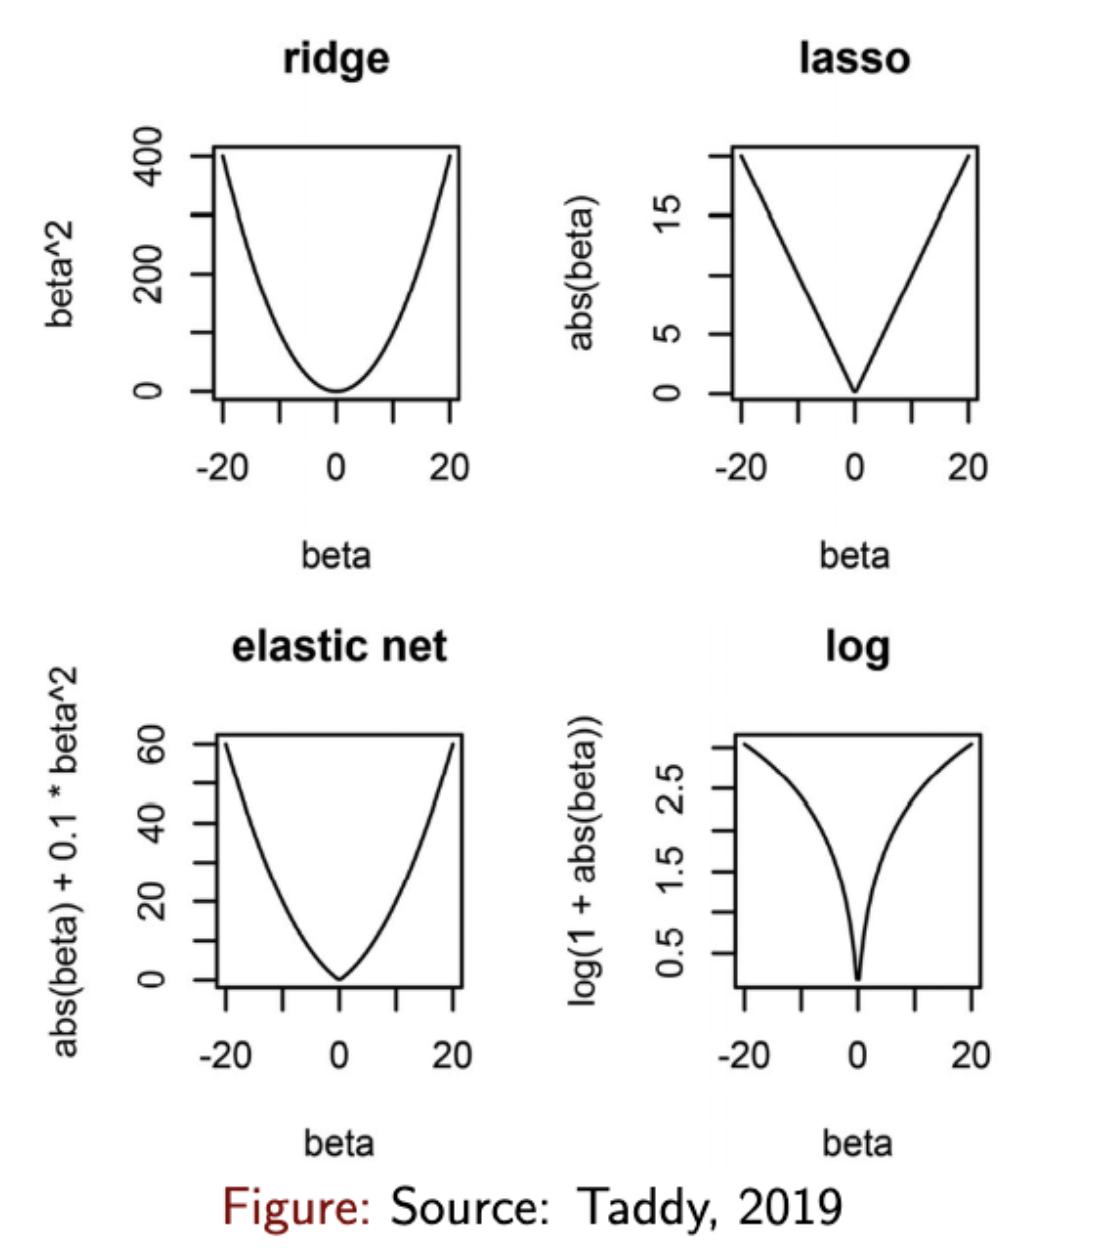
</div>


1. Lasso: Penalizes the model to a large extent, driving a lot of the estimates to 0. This feature also makes this model useful in feature selection (only factors with non-zero estimates are useful)

2. Ridge: Shrinks the estimates to as small as possible, with less intensity. Useful when you want to capture all the possible factors but limit how much weight is assigned to each factor.

Ridge model in-sample performance: 76.85%
Ridge model out-of-sample performance: 32.21%
Lasso model in-sample performance: 78.86%
Lasso model out-of-sample performance: 46.55%


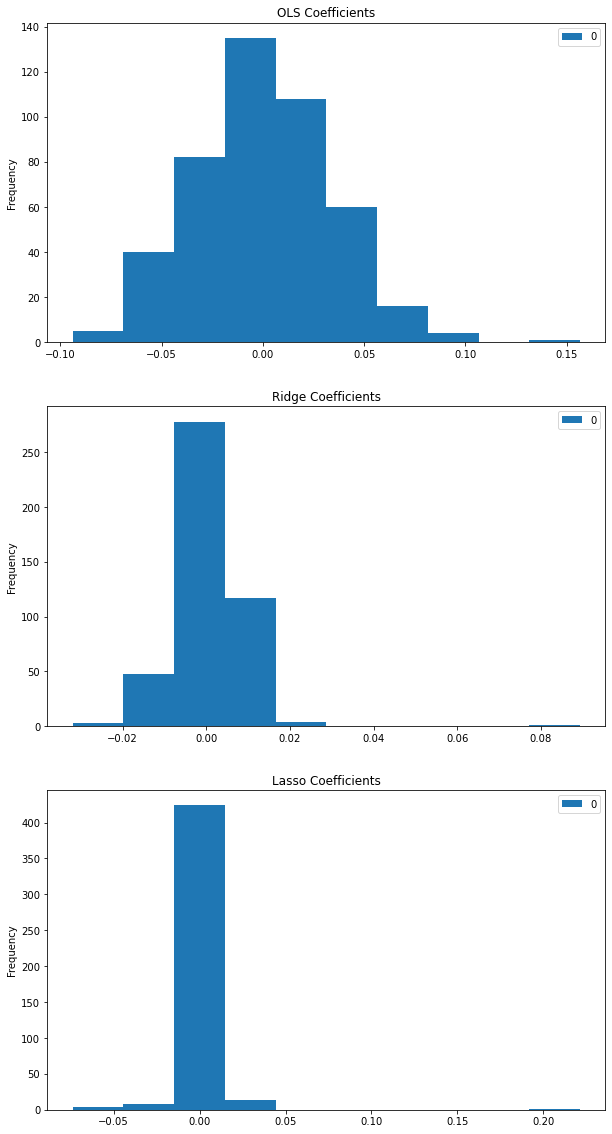

In [6]:
# Ridge Model (Lambda = 0.5)

model_Ridge = Ridge(alpha=0.5, fit_intercept=True).fit(retsx_train, gld_train)
print("Ridge model in-sample performance: {:,.2%}".format(model_Ridge.score(retsx_train, gld_train)))
print("Ridge model out-of-sample performance: {:,.2%}".format(model_Ridge.score(retsx_test, gld_test)))


#Lasso Model (Lambda = 2e-5)
model_Lasso = Lasso(alpha=2e-5, fit_intercept=True).fit(retsx_train, gld_train)
print("Lasso model in-sample performance: {:,.2%}".format(model_Lasso.score(retsx_train, gld_train)))
print("Lasso model out-of-sample performance: {:,.2%}".format(model_Lasso.score(retsx_test, gld_test)))


fig, ax = plt.subplots(3,1, figsize = (10,20))

pd.DataFrame(model.coef_.transpose()).plot(kind='hist', bins=10, title='OLS Coefficients', ax = ax[0])
pd.DataFrame(model_Ridge.coef_.transpose()).plot(kind='hist', bins=10, title='Ridge Coefficients', ax = ax[1])
pd.DataFrame(model_Lasso.coef_.transpose()).plot(kind='hist', bins=10, title='Lasso Coefficients', ax = ax[2])
plt.show()

## Selection of Lambda: Cross Validation and Generalization Error

The generalization performance of a learning method relates to its prediction capability on independent test data.
Assessment of this performance is extremely important in practice, since it guides the choice of learning method or model, and gives us a measure of the quality of the ultimately chosen model.

<div>
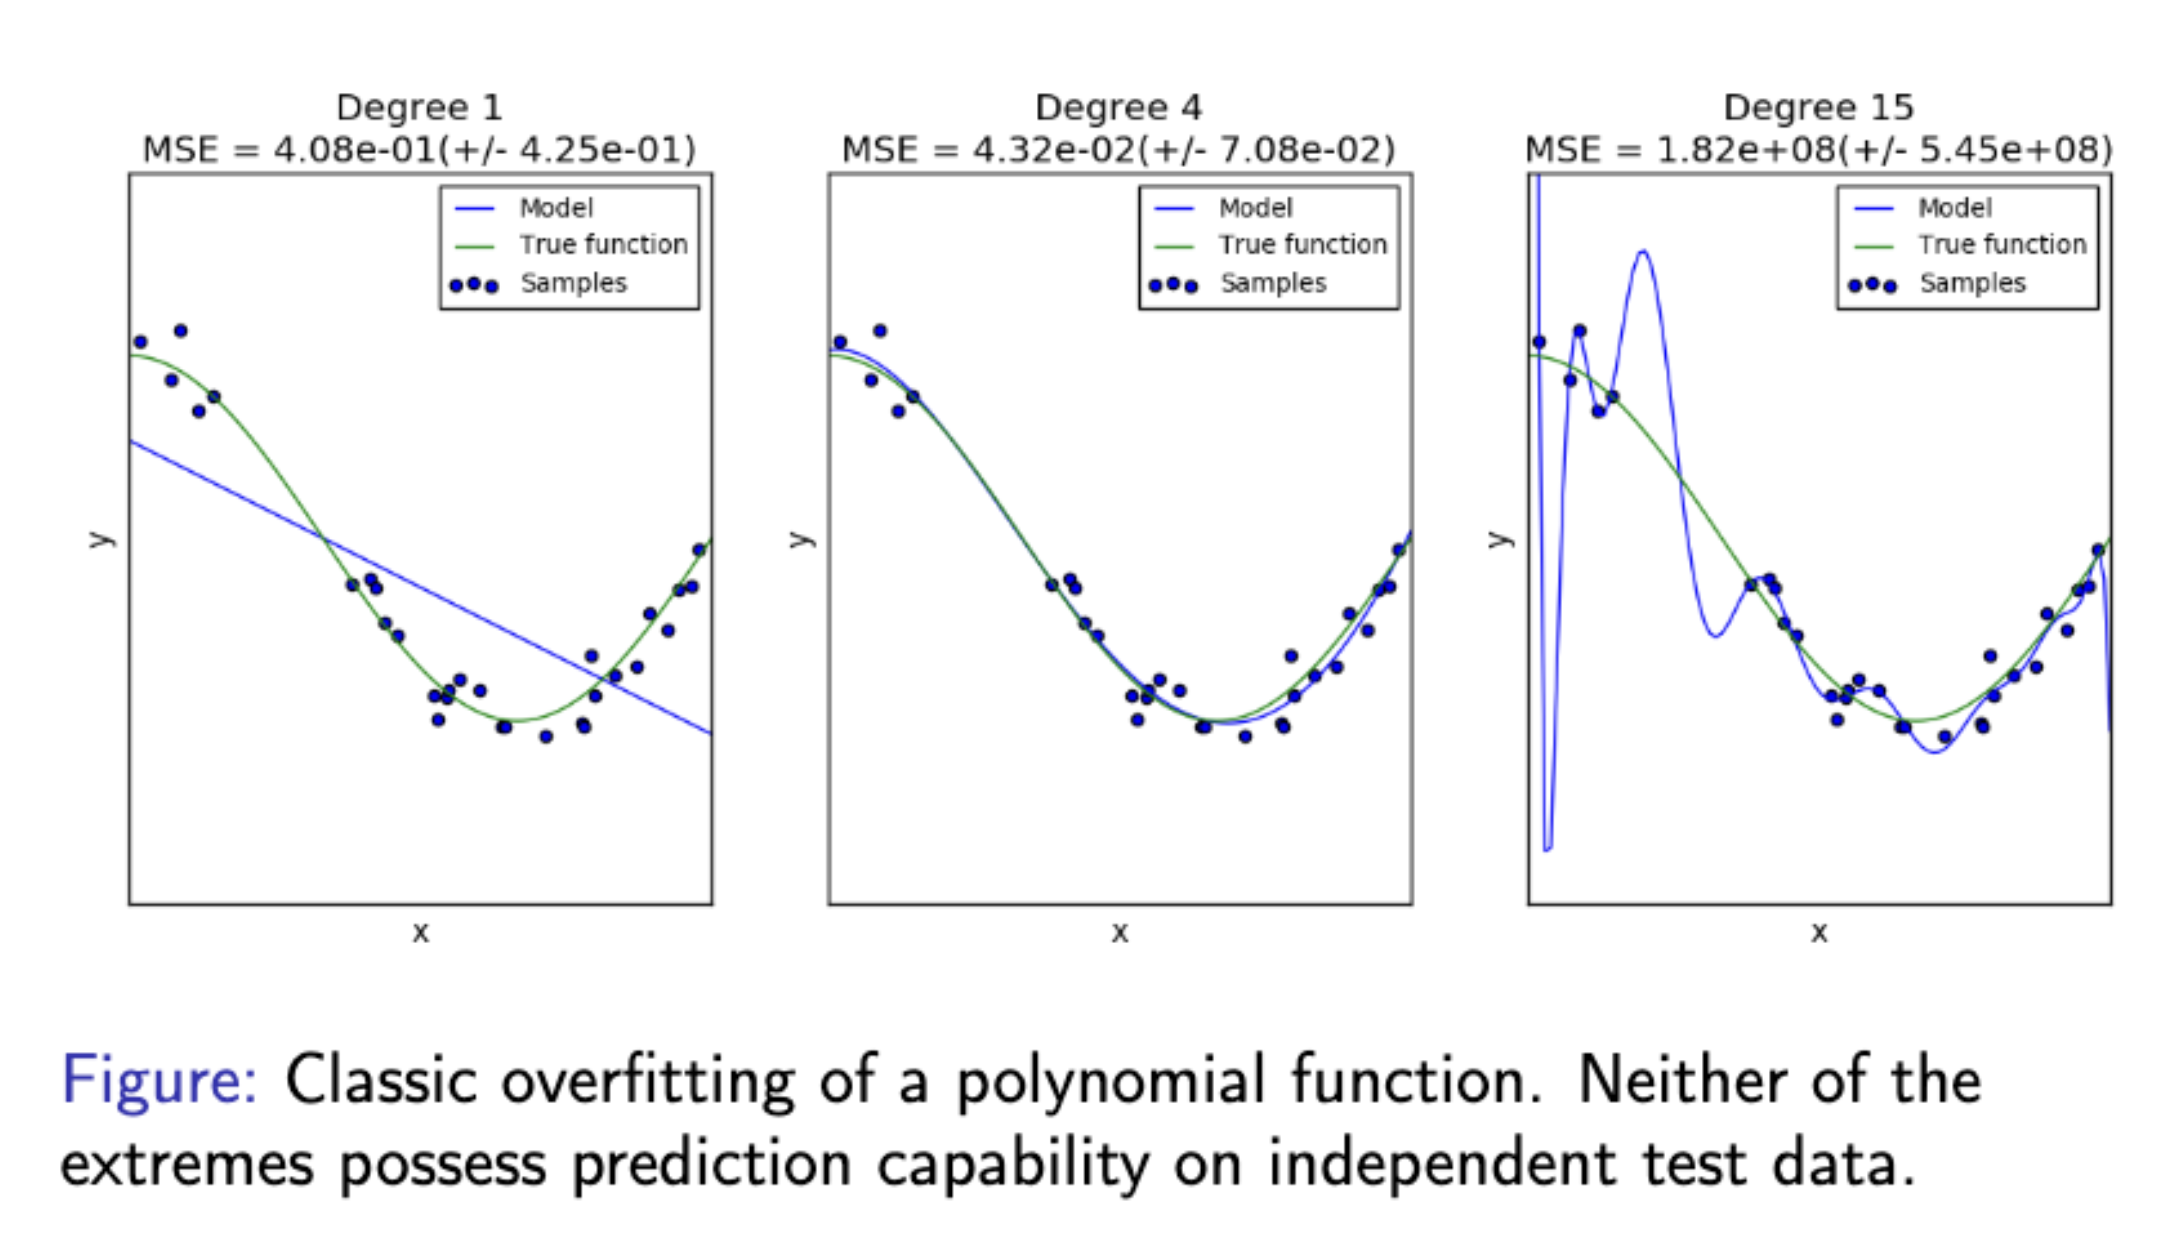
</div>

Let $Y$ be a target variable, $X$ be a vector of input variables and $\hat{f}(x)$ a prediction model trained on training sample $\tau$ containing training instantces $y_i$ and $x_i$.

**Training Error**

$$
err = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{f}(x_i)|^2 
$$

**Testing Error**

$$
Err = \frac{1}{n}\sum_{i=1}^{n}|Y - \hat{f}(X)|^2 
$$

- We would like to know the expected test error of our estimated model $\hat{f}$ .


- As the model becomes more and more complex, it uses the training data more and is able to adapt to more complicated underlying structures.


- Hence there is a decrease in bias but an increase in variance.


- There is some intermediate model complexity that gives minimum expected test error.

<div>
    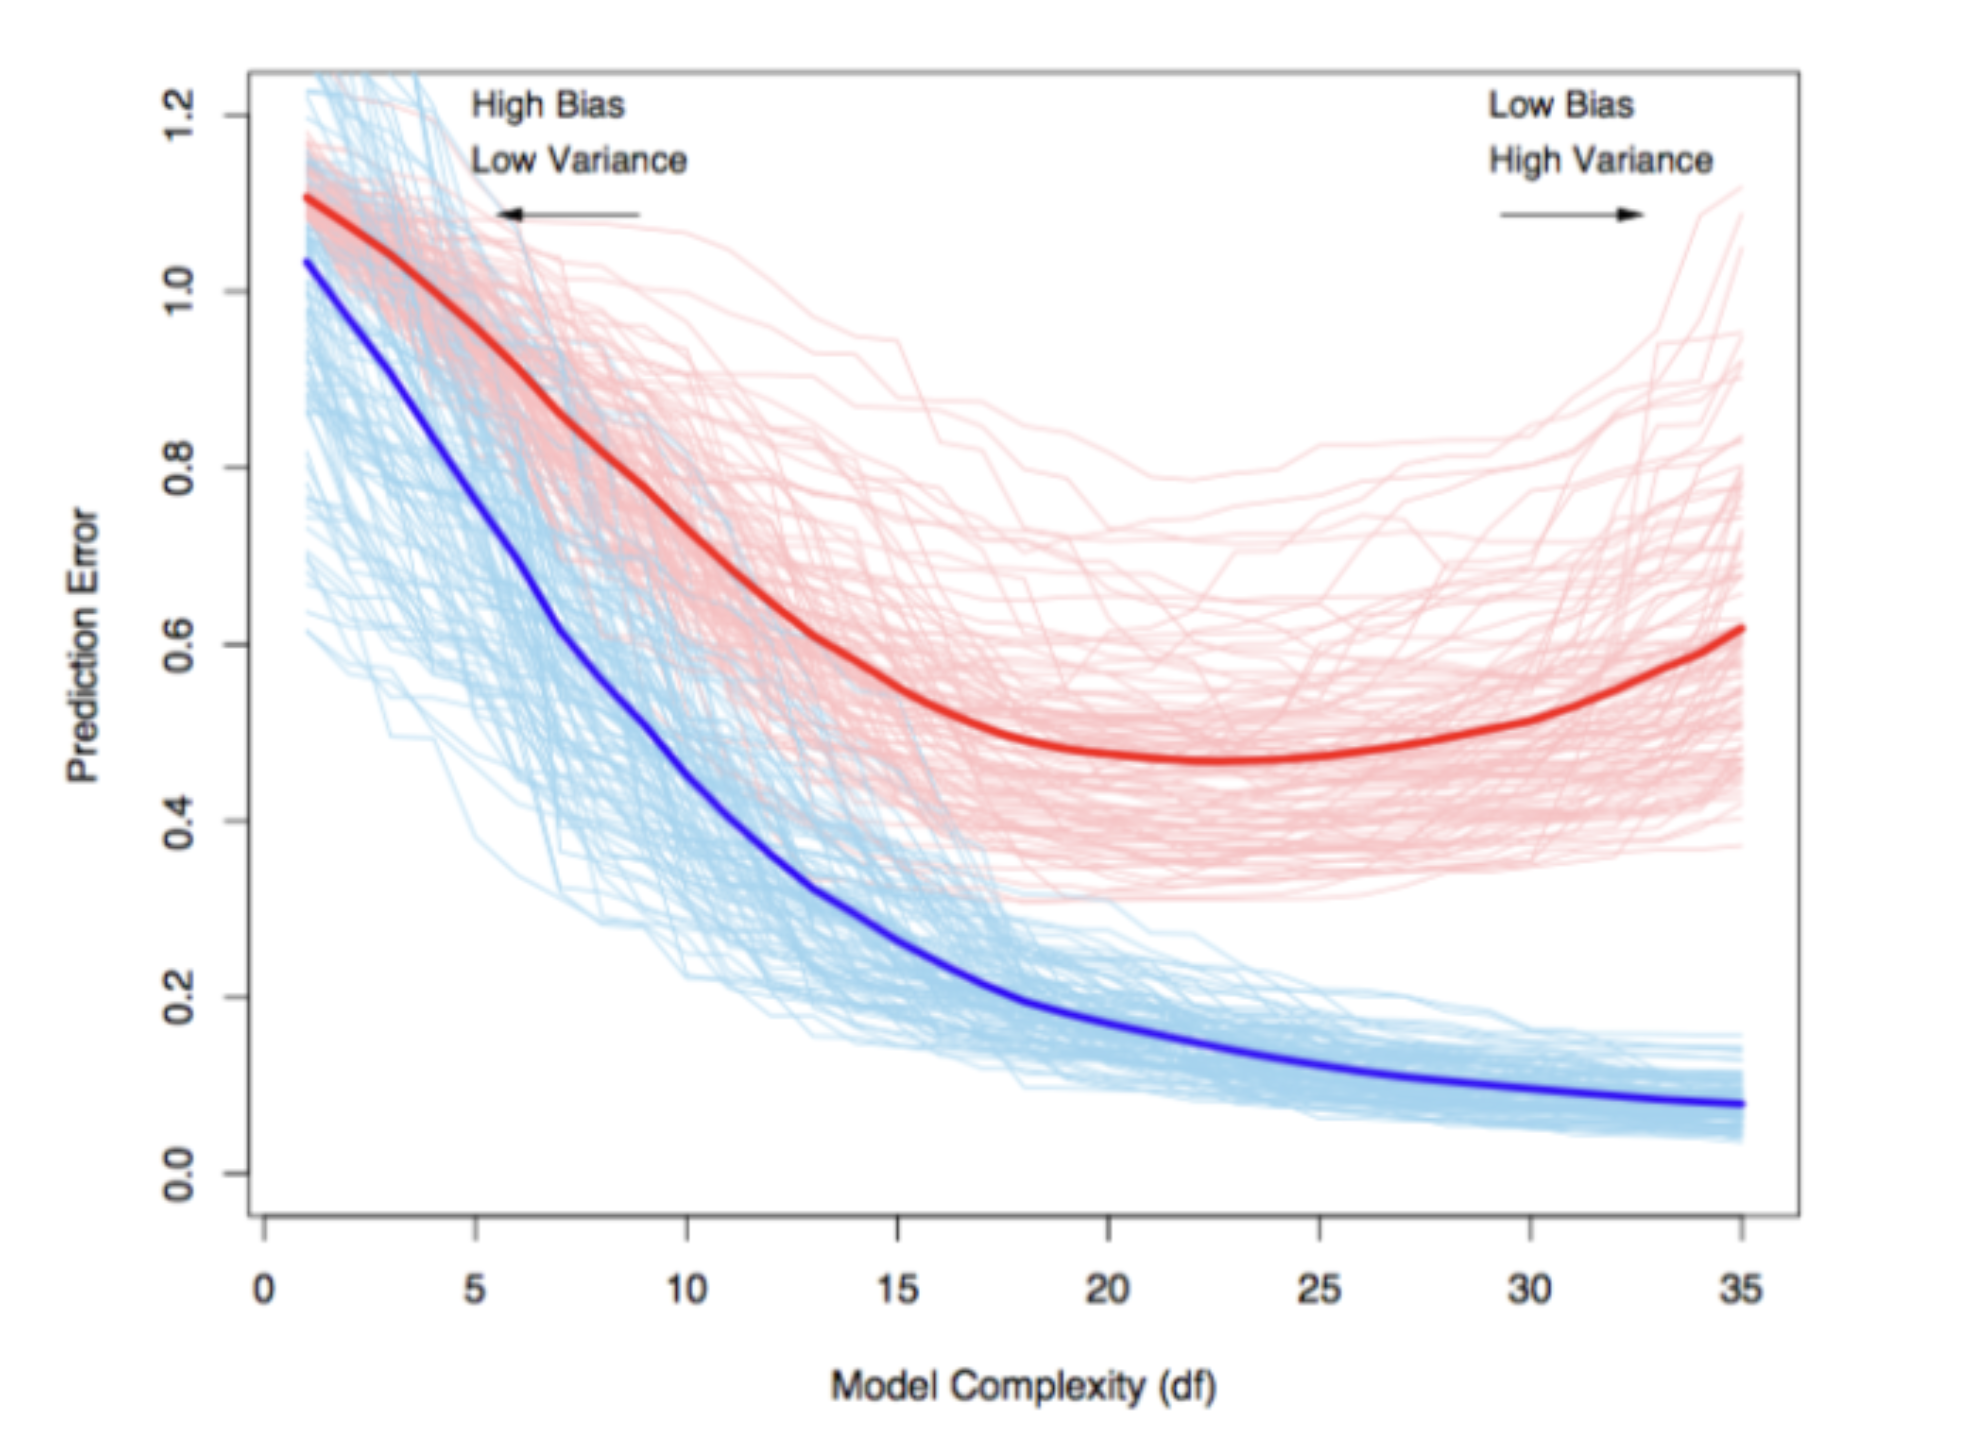
</div>

Behavior of test sample and training sample error as the model complexity is varied. The light blue curves show the training error $err$, while the light red curves show the conditional test error $Err$ as the model complexity is increased.

How do we get the OOS data?

- One can hold out the final portion of the sample, but then results are impacted by specifics of this one period.


- A more general approach is to use K-folds, which just means multiple subsamples.

Use K-fold CV to optimize $λ$ (model complexity)

- Select a sequence of $λ_i$


- Divide into K-folds


- For each $λ_i$ , estimate the model using K-fold CV to obtain K sets of OOS loss, (such as sum of squared errors.)


- Select the $λ_i$ that minimizes the simple average of the (K sets of) OOS loss values.

In [7]:
ridge_cv = RidgeCV().fit(retsx_train, gld_train)
model_Ridge_cv = Ridge(alpha=ridge_cv.alpha_, fit_intercept=True).fit(retsx_train, gld_train)
# print("Optimized Lambda for Ridge: {:,.2%}".format(model_ridge_cv.alpha_))
# print("Ridge model in-sample performance: {:,.2%}".format(model_Ridge.score(retsx_train, gld_train)))
# print("Ridge model out-of-sample performance: {:,.2%}".format(model_Ridge.score(retsx_test, gld_test)))


lasso_cv = LassoCV().fit(retsx_train, gld_train)
model_Lasso_cv = Lasso(alpha= lasso_cv.alpha_, fit_intercept=True).fit(retsx_train, gld_train)
# print("Optimized Lambda for Lasso: {:,.2%}".format(model_lasso_cv.alpha_))
# print("Lasso model in-sample performance: {:,.2%}".format(model_Lasso.score(retsx_train, gld_train)))
# print("Lasso model out-of-sample performance: {:,.2%}".format(model_Lasso.score(retsx_test, gld_test)))

In [9]:
cv_results = pd.DataFrame(index = ['Lambda', 'In sample R-squared', 'Out-of-sample R-squared'], \
                          columns = ['OLS', 'Lasso w/o CV', 'Ridge w/o CV', 'Lasso CV', 'Ridge CV'])

cv_results['OLS'] = [0, model.score(retsx_train, gld_train), model.score(retsx_test, gld_test)]
cv_results['Ridge w/o CV'] = [0.5, model_Ridge.score(retsx_train, gld_train), model_Ridge.score(retsx_test, gld_test)]
cv_results['Lasso w/o CV'] = [2e-5, model_Lasso.score(retsx_train, gld_train), model_Lasso.score(retsx_test, gld_test)]
cv_results['Ridge CV'] = [ridge_cv.alpha_, model_Ridge_cv.score(retsx_train, gld_train), model_Ridge_cv.score(retsx_test, gld_test)]
cv_results['Lasso CV'] = [lasso_cv.alpha_, model_Lasso_cv.score(retsx_train, gld_train), model_Lasso_cv.score(retsx_test, gld_test)]

display(cv_results.style.format('{:,.2%}'))


,OLS,Lasso w/o CV,Ridge w/o CV,Lasso CV,Ridge CV
Lambda,0.00%,0.00%,50.00%,0.01%,10.00%
In sample R-squared,100.00%,78.86%,76.85%,62.23%,91.64%
Out-of-sample R-squared,-53.71%,46.55%,32.21%,50.55%,32.41%


## Conclusions:

### We discussed several improvements to OLS in the session

##### 1. Pseudoinverse method allows the esimation of inverse even in the rank deficient case.

##### 2. Taking an optimization approach to OLS allows us to add constraints to estimates, resulting in more robust estimates.

##### 3. Some constraints, such as the L1 norm (Lasso) or L2 norm (Ridge) are more useful than other constraints, since they allow reduction in complexity of the model.

##### 4. Model complexity can be further optimized by using cross-validation techniques resulting in better out-of-sample performance.